# Последовательные модели в Recsys

## I. Зачем мы хотим использовать факт последовательности ?


Утверждения

- Зачастую интеракции пользователей можно отсортировать по времени


- Если между интеракциями прошло МАЛО времени, они могут быть связаны некоторой логикой взаимодействия


- Если пользователь взаимодйствовал с айтемом давно, это может мало влиять на его текущее поведение


- Если мы будем учитывать порядок интеракций, мы сможем лучше понимать динамику интересов пользователей

<b>Вопросы обсудить:</b>

1) Вы недавно посмотрели фильм X, и потом после этого решили посмотреть фильм Y. Придумайте пример таких фильмов X, Y?


2) Вы только что прослушали три подряд песни X1, X2, X3, и потом решили найти и прослушать песню X4. В каком случае так может происходить?


3) Представьте, что вы рекомендуете человеку магазины и видите человека с такой упорядоченной историей:
    - зоомагазин, супермаркет, метрополитен, зоомагазин, кофейня, супермаркет, развлекательный сервис
   Порекомендуете ли совершить следующую покупку в зоомагазине?
   
4) Представьте, что вы рекомендуете человеку магазины и видите человека с такой упорядоченной историей:
    - зоомагазин, супермаркет, метрополитен, зоомагазин, кофейня, супермаркет, развлекательный сервис, зоомагазин
   Порекомендуете ли теперь совершить следующую покупку в зоомагазине?
   
   
5) Представим теперь, что у наша последовательность не отсортирована и мы просто знаем, что человек покупал в магазинах
    - зоомагазин, супермаркет, кофейня, развлекательный сервис
    
   Пора ли ему рекомендовать зоомагазин теперь?
   


<b>Главый вывод:</b> Учет последовательности интеракций может добавить больше информации о текущих интересах пользователя

## II. Попробуем что-то простое

Возьмем данные из ods соревнования от МТС по рекомендациям

https://ods.ai/competitions/competition-recsys-21/data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm


%matplotlib inline

In [2]:
!unzip ../../recsys_course.zip -d data/. -

Archive:  ../../recsys_course.zip
caution: filename not matched:  -


In [2]:
df = pd.read_csv('data/interactions.csv')
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['weekday'] = pd.to_datetime(df.last_watch_dt).dt.weekday

In [4]:
df.last_watch_dt.max()

'2021-08-22'

In [5]:
train_df = df.loc[(df.last_watch_dt < '2021-08-08')].copy()
valid_df = df.loc[(df.last_watch_dt >= '2021-08-08')&(df.last_watch_dt < '2021-08-15')].copy()
test_df = df.loc[(df.last_watch_dt >= '2021-08-15')].copy()

train_users = train_df.user_id.unique()
valid_users = valid_df.user_id.unique()
test_users = test_df.user_id.unique()


all_included = np.intersect1d(np.intersect1d(valid_users, train_users), test_users)

print('number of users which are included both in train/test data: ', all_included.shape[0])

number of users which are included both in train/test data:  48728


In [6]:
n_users = 5000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
valid_df = valid_df.loc[valid_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < valid_df.last_watch_dt.min()
assert valid_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert valid_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users


In [7]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2, t3) for t1, t2, t3 in sorted(zip(x.item_id, 
                                                 x.last_watch_dt,
                                                 x.weekday), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

valid_grouped = valid_df.groupby('user_id').apply(
    lambda x: [(t1, t2, t3) for t1, t2, t3 in sorted(zip(x.item_id,
                                                         x.last_watch_dt,
                                                         x.weekday), key=lambda x: x[1])]
).reset_index()
valid_grouped.rename({0:'valid_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2, t3) for t1, t2, t3 in sorted(zip(x.item_id,
                                                         x.last_watch_dt,
                                                         x.weekday), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)


train_grouped.head()

,user_id,train_interactions
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ..."
1,229,"[(11275, 2021-07-01, 3), (4151, 2021-07-01, 3)..."
2,576,"[(1731, 2021-03-13, 5), (14703, 2021-03-13, 5)..."
3,655,"[(15942, 2021-07-19, 0), (6273, 2021-07-20, 1)..."
4,733,"[(4946, 2021-08-07, 5), (5693, 2021-08-07, 5),..."


In [8]:
joined = train_grouped.merge(valid_grouped).merge(test_grouped)
joined.head()

,user_id,train_interactions,valid_interactions,test_interactions
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ...","[(3031, 2021-08-11, 2), (16484, 2021-08-11, 2)...","[(8584, 2021-08-16, 0), (4181, 2021-08-20, 4),..."
1,229,"[(11275, 2021-07-01, 3), (4151, 2021-07-01, 3)...","[(11237, 2021-08-10, 1), (14910, 2021-08-13, 4)]","[(10440, 2021-08-20, 4), (3697, 2021-08-21, 5)]"
2,576,"[(1731, 2021-03-13, 5), (14703, 2021-03-13, 5)...","[(3059, 2021-08-11, 2), (956, 2021-08-11, 2), ...","[(4191, 2021-08-17, 1), (7528, 2021-08-19, 3),..."
3,655,"[(15942, 2021-07-19, 0), (6273, 2021-07-20, 1)...","[(11899, 2021-08-10, 1), (3343, 2021-08-10, 1)...","[(15051, 2021-08-15, 6), (15423, 2021-08-16, 0..."
4,733,"[(4946, 2021-08-07, 5), (5693, 2021-08-07, 5),...","[(9343, 2021-08-09, 0), (2892, 2021-08-09, 0),...","[(4731, 2021-08-17, 1), (5124, 2021-08-17, 1),..."


с этим уже можно работать

In [9]:
def ndcg_metric(gt_items, predicted):
    
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)


def recall_metric(gt_items, predicted):
    
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt



def evaluate_recommender(df, model_preds, gt_col='test_interactions', topn=10):
    
    metric_values = []
    
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]),
                              recall_metric(gt_items, row[model_preds])))
        
    return {'ndcg':np.mean([x[0] for x in metric_values]),
            'recall':np.mean([x[1] for x in metric_values])}
            


In [10]:
def get_metrics(df, model_preds, gt_col='test_interactions', topn=10):
    
    metric_values = []
    
    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        metric_values.append((ndcg_metric(gt_items, row[model_preds]),
                              recall_metric(gt_items, row[model_preds])))
        
    return metric_values
        

In [11]:
class TopPopular:

    def __init__(self):

        self.trained = False
    
    def fit(self, df, col='train_interactions'):
        
        counts = {}
        for _, row in df.iterrows():
            for item, _, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1
                    
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        self.recommenations = [x[0] for x in counts]
        self.trained = True
        
    def predict(self, df, topn=10)  -> List[np.ndarray]:
        
        assert self.trained
        return [self.recommenations[:topn]]*len(df)

    
toppop = TopPopular()
toppop.fit(joined)
joined['toppopular_recs'] = toppop.predict(joined)
joined.head()       

,user_id,train_interactions,valid_interactions,test_interactions,toppopular_recs
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ...","[(3031, 2021-08-11, 2), (16484, 2021-08-11, 2)...","[(8584, 2021-08-16, 0), (4181, 2021-08-20, 4),...","[9728, 10440, 15297, 13865, 3734, 4151, 4880, ..."
1,229,"[(11275, 2021-07-01, 3), (4151, 2021-07-01, 3)...","[(11237, 2021-08-10, 1), (14910, 2021-08-13, 4)]","[(10440, 2021-08-20, 4), (3697, 2021-08-21, 5)]","[9728, 10440, 15297, 13865, 3734, 4151, 4880, ..."
2,576,"[(1731, 2021-03-13, 5), (14703, 2021-03-13, 5)...","[(3059, 2021-08-11, 2), (956, 2021-08-11, 2), ...","[(4191, 2021-08-17, 1), (7528, 2021-08-19, 3),...","[9728, 10440, 15297, 13865, 3734, 4151, 4880, ..."
3,655,"[(15942, 2021-07-19, 0), (6273, 2021-07-20, 1)...","[(11899, 2021-08-10, 1), (3343, 2021-08-10, 1)...","[(15051, 2021-08-15, 6), (15423, 2021-08-16, 0...","[9728, 10440, 15297, 13865, 3734, 4151, 4880, ..."
4,733,"[(4946, 2021-08-07, 5), (5693, 2021-08-07, 5),...","[(9343, 2021-08-09, 0), (2892, 2021-08-09, 0),...","[(4731, 2021-08-17, 1), (5124, 2021-08-17, 1),...","[9728, 10440, 15297, 13865, 3734, 4151, 4880, ..."


In [12]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'ndcg': 0.15494205816767317, 'recall': 0.09707992750089679}

В нашем алгоритме есть маленький недостаток: какой?

Он может порекомендовать то, что уже было в истории. В recsys всегда стоит сразу смотреть на то, есть ли дубли в датасете по user-item парам. Если нет, то надо удалять в рекомендациях. Если есть, то скорее всего оставлять

Поэтому отредактируем predict метод

In [13]:
class ModifiedTopPopular(TopPopular):

    def __init__(self):

        self.trained = False

        
    def predict(self, df, topn=10)  -> List[np.ndarray]:
        
        assert self.trained
        
        all_recs = []
        
        
        for idx, row in df.iterrows():
            
            user_recs = []
            
            user_interactions = [x[0] for x in row['train_interactions']]
            user_interactions += [x[0] for x in row['valid_interactions']]
            
            user_interactions = set(user_interactions)
            
            for elem in self.recommenations:
                if elem not in user_interactions:
                    user_recs.append(elem)
                    
                if len(user_recs) == topn:
                    break
                    
            all_recs.append(user_recs)
                
        return all_recs

    
toppop = ModifiedTopPopular()
toppop.fit(joined)
joined['toppopular_recs'] = toppop.predict(joined)
joined.head()       

,user_id,train_interactions,valid_interactions,test_interactions,toppopular_recs
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ...","[(3031, 2021-08-11, 2), (16484, 2021-08-11, 2)...","[(8584, 2021-08-16, 0), (4181, 2021-08-20, 4),...","[10440, 15297, 13865, 3734, 4151, 4880, 2657, ..."
1,229,"[(11275, 2021-07-01, 3), (4151, 2021-07-01, 3)...","[(11237, 2021-08-10, 1), (14910, 2021-08-13, 4)]","[(10440, 2021-08-20, 4), (3697, 2021-08-21, 5)]","[9728, 10440, 13865, 3734, 4880, 2657, 142, 86..."
2,576,"[(1731, 2021-03-13, 5), (14703, 2021-03-13, 5)...","[(3059, 2021-08-11, 2), (956, 2021-08-11, 2), ...","[(4191, 2021-08-17, 1), (7528, 2021-08-19, 3),...","[10440, 15297, 3734, 4151, 4880, 142, 9996, 44..."
3,655,"[(15942, 2021-07-19, 0), (6273, 2021-07-20, 1)...","[(11899, 2021-08-10, 1), (3343, 2021-08-10, 1)...","[(15051, 2021-08-15, 6), (15423, 2021-08-16, 0...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1..."
4,733,"[(4946, 2021-08-07, 5), (5693, 2021-08-07, 5),...","[(9343, 2021-08-09, 0), (2892, 2021-08-09, 0),...","[(4731, 2021-08-17, 1), (5124, 2021-08-17, 1),...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1..."


In [14]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'ndcg': 0.18407826659038715, 'recall': 0.11809654507778314}

Качество ожидаемо улучшилось

## III. Начинаем учитывать последовательности

давайте реализуем пример, когда мы рекомендуем "следующий фильм" по предыдущему

Идея простая. Давайте для каждого фильма посчитаем, какие фильмы пользователи смотрят сразу после? И эти фильмы будем рекомендовать

In [15]:
from collections import defaultdict, Counter

def increase_value_in_dict(d, key):

    if key in d:
        d[key] += 1
    else:
        d[key] = 1
        


class LastPopular:

    def __init__(self):

        self.trained = False
    
    def fit(self, df, col='train_interactions'):
        
        overall_popularity = {}
        
        transition_matrix = defaultdict(list)
        for _, row in df.iterrows():
            
            if len(row[col]) == 1:
                continue

            increase_value_in_dict(overall_popularity, row[col][0][0])
                
            for inter_prev, inter_next in zip(row[col][:-1], row[col][1:]):
                item_prev, item_next = inter_prev[0], inter_next[0]
                
                transition_matrix[item_prev].append(item_next)

                increase_value_in_dict(overall_popularity, item_next)


        item2recs = {}
        for item in transition_matrix:
            
            temp_counts = Counter(transition_matrix[item]).most_common() 
            item2recs[item] = [x[0] for x in temp_counts]
                
                
        self.item2recs = item2recs.copy()
        self.overall_popularity = [x[0] for x in sorted(overall_popularity.items(),
                                                        key=lambda x: x[1],
                                                        reverse=True)]
        self.trained = True
        
    def predict(self, df, topn=10) -> List[np.ndarray]:
        
        assert self.trained
         
        all_recs = []
        
        
        for idx, row in tqdm(df.iterrows()):
            
            user_recs = []
            
            user_interactions = [x[0] for x in row['train_interactions']]
            user_interactions += [x[0] for x in row['valid_interactions']]
            
            for item in user_interactions[::-1]:
                
                if item in self.item2recs:
                    user_recs.extend([x for x in self.item2recs[item] \
                                      if x not in user_interactions and  x not in user_recs])
                    
                if len(user_recs) >= topn:
                    break
                    
            user_interactions = set(user_interactions)
            if len(user_recs) < topn:

                for el in self.overall_popularity:
                    if el not in user_recs and el not in user_interactions:
                        user_recs.append(el)

                    if len(user_recs) >= topn:
                        break

            all_recs.append(user_recs[:topn])
                
        return all_recs


lp1 = LastPopular()
lp1.fit(joined)
joined['last_popular'] = lp1.predict(joined)


5000it [00:00, 8762.06it/s]


In [16]:
evaluate_recommender(joined, model_preds='last_popular')

{'ndcg': 0.12486415315014132, 'recall': 0.078244659274838}

Есть ли идеи, как улучшить?

In [17]:
joined[['ndcg_last_pop','recall_last_pop']] = get_metrics(joined,model_preds='last_popular')
joined[['ndcg_pop','recall_pop']] = get_metrics(joined,model_preds='toppopular_recs')
joined.head()

,user_id,train_interactions,valid_interactions,test_interactions,toppopular_recs,last_popular,ndcg_last_pop,recall_last_pop,ndcg_pop,recall_pop
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ...","[(3031, 2021-08-11, 2), (16484, 2021-08-11, 2)...","[(8584, 2021-08-16, 0), (4181, 2021-08-20, 4),...","[10440, 15297, 13865, 3734, 4151, 4880, 2657, ...","[2351, 11112, 657, 12623, 1290, 11754, 16361, ...",0.000000,0.0,0.5,0.333333
1,229,"[(11275, 2021-07-01, 3), (4151, 2021-07-01, 3)...","[(11237, 2021-08-10, 1), (14910, 2021-08-13, 4)]","[(10440, 2021-08-20, 4), (3697, 2021-08-21, 5)]","[9728, 10440, 13865, 3734, 4880, 2657, 142, 86...","[15739, 6965, 10772, 16442, 7102, 2296, 10994,...",0.000000,0.0,1.0,0.500000
2,576,"[(1731, 2021-03-13, 5), (14703, 2021-03-13, 5)...","[(3059, 2021-08-11, 2), (956, 2021-08-11, 2), ...","[(4191, 2021-08-17, 1), (7528, 2021-08-19, 3),...","[10440, 15297, 3734, 4151, 4880, 142, 9996, 44...","[5311, 7019, 15679, 760, 6033, 5434, 14488, 12...",0.430677,0.2,0.0,0.000000
3,655,"[(15942, 2021-07-19, 0), (6273, 2021-07-20, 1)...","[(11899, 2021-08-10, 1), (3343, 2021-08-10, 1)...","[(15051, 2021-08-15, 6), (15423, 2021-08-16, 0...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[13218, 9628, 1215, 12192, 16152, 7408, 7793, ...",0.000000,0.0,0.0,0.000000
4,733,"[(4946, 2021-08-07, 5), (5693, 2021-08-07, 5),...","[(9343, 2021-08-09, 0), (2892, 2021-08-09, 0),...","[(4731, 2021-08-17, 1), (5124, 2021-08-17, 1),...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[4151, 10440, 9728, 3734, 2657, 13865, 9996, 1...",0.000000,0.0,0.0,0.000000


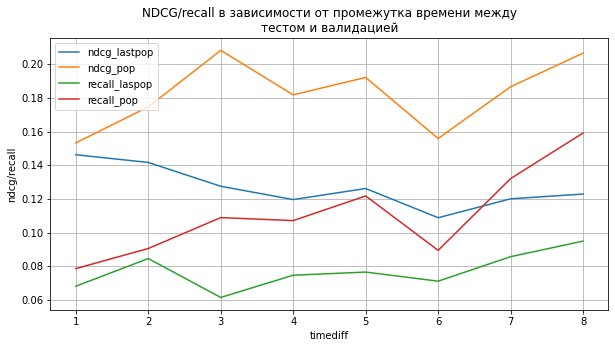

In [18]:
def get_timediff_valid_test_interactions(row):
    
    last_valid_inter = row.valid_interactions[-1][1]
    first_test_inter = row.test_interactions[0][1]
    
    days = int(first_test_inter.split('-')[2]) - int(last_valid_inter.split('-')[2])
    return days
    
    
joined['timediff'] = joined.apply(get_timediff_valid_test_interactions, axis=1)
xy = joined.groupby('timediff').agg({'ndcg_last_pop':'mean', 'recall_last_pop':'mean',
                                     'ndcg_pop':'mean', 'recall_pop':'mean',
                                     'user_id':'count'})[:8]

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(xy.index, xy.ndcg_last_pop, label='ndcg_lastpop')
ax.plot(xy.index, xy.ndcg_pop, label='ndcg_pop')
ax.set_title('NDCG/recall в зависимости от промежутка времени между\nтестом и валидацией')
ax.set_xlabel('timediff')
ax.set_ylabel('ndcg/recall')

ax.plot(xy.index, xy.recall_last_pop, label='recall_laspop')
ax.plot(xy.index, xy.recall_pop, label='recall_pop')
ax.legend()

ax.grid()

plt.show()

Вопросы: 

Почему lastpop деградирует при большем timediff?

Как нам поможет эта информация модифировать метод?


In [19]:

class LastPopularDiffAware(LastPopular):

    def __init__(self):

        self.trained = False
    
        
    def predict(self, df, switch_time_diff=2,topn=10) -> List[np.ndarray]:
        
        assert self.trained
         
        all_recs = []
        
        
        for idx, row in tqdm(df.iterrows()):
            
            user_recs = []
            
            user_interactions = [x[0] for x in row['train_interactions']]
            user_interactions += [x[0] for x in row['valid_interactions']]
            
            for item in user_interactions[::-1]:
                
                if row['timediff'] < switch_time_diff:
                
                    if item in self.item2recs:
                        user_recs.extend([x for x in self.item2recs[item] \
                                          if x not in user_interactions and  x not in user_recs])

                    if len(user_recs) >= topn:
                        break
                    
            user_interactions = set(user_interactions)
            
            if len(user_recs) < topn:
                
                for el in self.overall_popularity:
                    if el not in user_recs and el not in user_interactions:
                        user_recs.append(el)
                        
                    if len(user_recs) >= topn:
                        break
                        

                
            all_recs.append(user_recs[:topn])
                
        return all_recs
    
    
lp1 = LastPopularDiffAware()
lp1.fit(joined)
joined['last_popular_diff'] = lp1.predict(joined)


5000it [00:00, 8297.97it/s]


In [20]:
evaluate_recommender(joined, model_preds='last_popular_diff')

{'ndcg': 0.1829229136032898, 'recall': 0.11647604506909406}

таким образом мы улучшили немного метрики просто на эвристики, что рекомендуем что-то похожее на последний фильм только тем, кто недавно зашел в тестовую интеракцию

## IV. Векторные представления

давайте выучим айтемы и их похожести друг на друга

In [21]:
import gensim.models


class Word2vecSimilar(LastPopular):

    def __init__(self):

        self.trained = False
    
    def fit(self, df, col='train_interactions'):
        
        overall_popularity = {}
        
        sentences = []

        for _, row in df.iterrows():
            sentences.append([x[0] for x in row[col]])
            
            for x in row[col]:
                increase_value_in_dict(overall_popularity, x[0])
                
        self.overall_popularity = [x[0] for x in sorted(overall_popularity.items(),
                                                key=lambda x: x[1],
                                                reverse=True)]

        model = gensim.models.Word2Vec(sentences=sentences, min_count=5, window=3, vector_size=64)

        item2recs = {}
        for item in tqdm(overall_popularity):
            
            if item in model.wv:
                temp_counts = model.wv.similar_by_word(item, topn=200,)
            else:
                temp_counts = [(x, 0) for x in self.overall_popularity]
            item2recs[item] = [x[0] for x in temp_counts]
                
                
        self.item2recs = item2recs.copy()

        self.trained = True
        

w2v_model = Word2vecSimilar()
w2v_model.fit(joined)
joined['w2v_preds'] = w2v_model.predict(joined) 

100%|██████████| 6590/6590 [00:03<00:00, 1665.17it/s]
5000it [00:01, 3622.88it/s]


In [22]:
evaluate_recommender(joined, model_preds='w2v_preds')

{'ndcg': 0.07220352276755229, 'recall': 0.044180266231670484}

очень плохо, в чем может быть дело?

In [23]:
class Word2vecSimilarModified(LastPopular):

    def __init__(self):

        self.trained = False
    
    def fit(self, df, col='train_interactions'):
        
        overall_popularity = {}
        
        sentences = []
        

        for _, row in tqdm(df.iterrows()):
            
            cur_sentence = []
            cur_day = None
            
            for x in row[col]:
                if cur_day is None:
                    cur_day = x[1]
                    cur_sentence = [x[0]]
                    continue
                    
                if (pd.to_datetime(x[1])-pd.to_datetime(cur_day)).days < 2:
                    cur_sentence.append(x[0])
                else:
                    if len(cur_sentence) >1:
                        sentences.append(cur_sentence)
                        
                    cur_sentence = []
                    
                cur_day = x[1]
                    
            
            for x in row[col]:
                increase_value_in_dict(overall_popularity, x[0])
                
        self.overall_popularity = [x[0] for x in sorted(overall_popularity.items(),
                                                key=lambda x: x[1],
                                                reverse=True)]

        model = gensim.models.Word2Vec(sentences=sentences,min_count=5, window=3, vector_size=64)

        item2recs = {}
        for item in tqdm(overall_popularity):
            
            if item in model.wv:
                temp_counts = model.wv.similar_by_word(item, topn=200,)
            else:
                temp_counts = [(x, 0) for x in self.overall_popularity]
            item2recs[item] = [x[0] for x in temp_counts]
                
                
        self.item2recs = item2recs.copy()

        self.trained = True
        
        
        
w2v_model = Word2vecSimilarModified()
w2v_model.fit(joined)
joined['w2v_modified_preds'] = w2v_model.predict(joined) 

5000it [00:14, 344.76it/s]
100%|██████████| 6590/6590 [00:04<00:00, 1510.46it/s]
5000it [00:02, 2177.75it/s]


In [24]:
evaluate_recommender(joined, model_preds='w2v_modified_preds')

{'ndcg': 0.09222044827086491, 'recall': 0.05491137981080236}

Стало немного лучше, но намного хуже toppopular. Как вы думаете, почему?

Минутка саморекламы, w2v может быть неплохим recommender. Вот наша статья на хабр, как мы с помощью w2v заняли 4 из 11 мест в научном recsys-соревновании https://habr.com/ru/company/tinkoff/blog/575944/

## V. Построим более менее нормальную модель

по факту у нас есть вот такие последовательности

<img src="images/1.png">

поэтому мы можем решать задачу next-item recommendation через NLP-методы

<b>Вопросы:</b>

1) Что мы можем не учесть, перенеся  nlp методs в recsys?

Сразу посмотрим в сторону transformer

<img src='images/2.png'>
<img src='images/3.png'>

SASRec - 2018 год  832 цитирований в день семинара

BERT4REC - 2019 год  613 цитирований в день семинара

<img src='images/4.png'>

In [25]:
!pip3 install catalyst==21.12

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [26]:
import catalyst 
import recbole

In [27]:
recbole.__version__, catalyst.__version__

('1.0.1', '21.12')

In [28]:
# flake8: noqa
from typing import Dict, List, Tuple

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.init import constant_, xavier_normal_
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from catalyst import dl, metrics
from catalyst.contrib.datasets import MovieLens
from catalyst.utils import get_device, set_global_seed
from torch.nn.utils.rnn import pad_sequence 

set_global_seed(42)
device = get_device()
print(device)

cpu


надо закодировать айтемы, чтобы составлять тензоры и тд

In [29]:
our_items = set()
for idx, row in tqdm(joined.iterrows()):
    for el in row.train_interactions:
        our_items.add(el[0])
        
len(our_items)

5000it [00:00, 18112.08it/s]


6590

In [30]:
item2idx = {k: i for i, k in enumerate(our_items)}
idx2item = {i: k for k, i in item2idx.items()}

In [31]:
joined.head(1)

,user_id,train_interactions,valid_interactions,test_interactions,toppopular_recs,last_popular,ndcg_last_pop,recall_last_pop,ndcg_pop,recall_pop,timediff,last_popular_diff,w2v_preds,w2v_modified_preds
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ...","[(3031, 2021-08-11, 2), (16484, 2021-08-11, 2)...","[(8584, 2021-08-16, 0), (4181, 2021-08-20, 4),...","[10440, 15297, 13865, 3734, 4151, 4880, 2657, ...","[2351, 11112, 657, 12623, 1290, 11754, 16361, ...",0.0,0.0,0.5,0.333333,2,"[10440, 15297, 13865, 3734, 4151, 4880, 2657, ...","[760, 4774, 11754, 10214, 5250, 14689, 5693, 1...","[6443, 7210, 12659, 16197, 10942, 14901, 10119..."


In [32]:
class MyDataset(Dataset):
    
    def __init__(self, ds, num_items, item2idx, phase='valid'):
        super().__init__()
        self.ds = ds
        self.phase = phase
        self.n_items = num_items
        self.item2idx = item2idx
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        
        row = self.ds.iloc[idx]
        
        x_input = np.zeros(self.n_items+1)
        x_input[[self.item2idx[x[0]]+1 for x in row['train_interactions'] if x[0] in self.item2idx]] = 1
        
        days_of_weeks = [x[2] for x in row['train_interactions'] if x[0] in self.item2idx][-99:]
        
        seq_input = [self.item2idx[x[0]]+1 for x in row['train_interactions'] if x[0] in self.item2idx][-99:]
        
        targets = np.zeros(self.n_items+1)
        
        dow_valid = row['valid_interactions'][0][2]
        dow_test = row['test_interactions'][0][2]
        
        if self.phase == 'train':
            return (seq_input, days_of_weeks, dow_valid)
        elif self.phase == 'valid':
            targets[[self.item2idx[x[0]]+1 for x in row['valid_interactions'] if x[0] in self.item2idx]] = 1
        else:
            return (seq_input,days_of_weeks,dow_test)
            
       # print(x_input.sum(), targets.sum())
        return (targets, seq_input,days_of_weeks,dow_valid)
     
n_items = len(item2idx)

train = MyDataset(ds=joined,
                  num_items=n_items, 
                  item2idx=item2idx,
                  phase='train')

valid = MyDataset(ds=joined,
                  num_items=n_items,
                  item2idx=item2idx,
                  phase='valid')

#test = MyDataset(ds=ds_grouped, num_items=n_items, phase='test')

print(len(train),len(valid))

5000 5000


In [33]:
def collate_fn_train(batch: List[Tuple[torch.Tensor]]) -> Dict[str, torch.Tensor]: 
    
    seq_i,days_of_weeks,dow_valid = zip(*batch)
    seq_len = torch.Tensor([len(x) for x in seq_i])
    dow_valid = torch.Tensor([x for x in dow_valid])
    seq_i = pad_sequence([torch.Tensor(t) for t in seq_i]).T    
    days_of_weeks = pad_sequence([torch.Tensor(t) for t in days_of_weeks]).T  
    
    return {'seq_i': seq_i, 
            'seq_len':seq_len,
            'dow': days_of_weeks,
            'dow_valid': dow_valid}


def collate_fn_valid(batch: List[Tuple[torch.Tensor]]) -> Dict[str, torch.Tensor]:
    
    y, seq_i, days_of_weeks, dow_valid = zip(*batch)
    
    seq_len = torch.Tensor([len(x) for x in seq_i]).long()
    seq_i = pad_sequence([torch.Tensor(t) for t in seq_i]).T.long()
    days_of_weeks = pad_sequence([torch.Tensor(t) for t in days_of_weeks]).T.long()
    dow_valid = torch.Tensor([x for x in dow_valid])
            
    targets = pad_sequence([torch.Tensor(t) for t in y]).T

    return {"targets": targets,
            'seq_i': seq_i,
            'seq_len':seq_len,
            'dow': days_of_weeks,
            'dow_valid': dow_valid}

In [34]:
loaders = {
        "train": DataLoader(train, batch_size=256, collate_fn=collate_fn_train),
        "valid": DataLoader(valid, batch_size=256, collate_fn=collate_fn_valid),
        #"infer": DataLoader(test, batch_size=32, collate_fn=collate_fn_valid),
}

In [35]:
for batch in loaders['train']:
    break

In [36]:
batch

{'seq_i': tensor([[1866.,  261., 4922.,  ...,    0.,    0.,    0.],
         [4482., 1626.,  674.,  ...,    0.,    0.,    0.],
         [ 411., 4306.,  492.,  ..., 3897., 6350., 6021.],
         ...,
         [1153., 6492., 4267.,  ...,    0.,    0.,    0.],
         [1403., 5719.,  506.,  ...,    0.,    0.,    0.],
         [1670., 4154., 6129.,  ...,    0.,    0.,    0.]]),
 'seq_len': tensor([10.,  8., 99., 11.,  7.,  8.,  2., 24., 13., 11.,  3.,  1.,  9., 10.,
          6.,  2., 28., 11., 26., 16., 19.,  4., 35., 47.,  3., 28.,  9., 21.,
          1., 17.,  9.,  5., 16.,  7., 13., 15., 15., 11., 20., 27.,  1.,  8.,
         65., 15., 20.,  3., 20., 29.,  4., 20., 13.,  7.,  6.,  3., 43., 95.,
          2.,  2.,  2., 24., 61., 14., 39.,  5., 82.,  3.,  2.,  4.,  2., 13.,
          3., 45.,  8.,  8.,  3.,  4.,  5.,  7.,  9.,  1., 15., 86.,  5.,  5.,
          1., 53., 22., 21., 13.,  3., 49., 51.,  1., 34., 99., 29.,  2., 14.,
          5.,  5.,  5.,  9.,  1.,  3., 28., 23., 21.,  1.

Теперь код bert4rec

In [37]:
import torch
import random


from torch import nn
from recbole.model.abstract_recommender import SequentialRecommender
from recbole.model.layers import *

In [38]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head Self-attention layers, a attention score dropout layer is introduced.
    Args:
        input_tensor (torch.Tensor): the input of the multi-head self-attention layer
        attention_mask (torch.Tensor): the attention mask for input tensor
    Returns:
        hidden_states (torch.Tensor): the output of the multi-head self-attention layer
    """

    def __init__(
        self,
        n_heads,
        hidden_size,
        hidden_dropout_prob,
        attn_dropout_prob,
        layer_norm_eps,
    ):
        super(MultiHeadAttention, self).__init__()
        if hidden_size % n_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, n_heads)
            )

        self.num_attention_heads = n_heads
        self.attention_head_size = int(hidden_size / n_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.sqrt_attention_head_size = math.sqrt(self.attention_head_size)

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.softmax = nn.Softmax(dim=-1)
        self.attn_dropout = nn.Dropout(attn_dropout_prob)

        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=layer_norm_eps)
        self.out_dropout = nn.Dropout(hidden_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_attention_heads,
            self.attention_head_size,
        )
        x = x.view(*new_x_shape)
        return x

    def forward(self, input_tensor, attention_mask, return_explanations=False):
        mixed_query_layer = self.query(input_tensor)
        mixed_key_layer = self.key(input_tensor)
        mixed_value_layer = self.value(input_tensor)

        query_layer = self.transpose_for_scores(mixed_query_layer).permute(0, 2, 1, 3)
        key_layer = self.transpose_for_scores(mixed_key_layer).permute(0, 2, 3, 1)
        value_layer = self.transpose_for_scores(mixed_value_layer).permute(0, 2, 1, 3)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer)

        attention_scores = attention_scores / self.sqrt_attention_head_size
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        # [batch_size heads seq_len seq_len] scores
        # [batch_size 1 1 seq_len]
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = self.softmax(attention_scores)
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.

        attention_probs = self.attn_dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        hidden_states = self.dense(context_layer)
        hidden_states = self.out_dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        
        if return_explanations:
            return hidden_states, attention_probs
        else:
            return hidden_states


In [39]:

class TransformerLayer(nn.Module):
    """
    One transformer layer consists of a multi-head self-attention layer and a point-wise feed-forward layer.
    Args:
        hidden_states (torch.Tensor): the input of the multi-head self-attention sublayer
        attention_mask (torch.Tensor): the attention mask for the multi-head self-attention sublayer
    Returns:
        feedforward_output (torch.Tensor): The output of the point-wise feed-forward sublayer,
                                           is the output of the transformer layer.
    """

    def __init__(
        self,
        n_heads,
        hidden_size,
        intermediate_size,
        hidden_dropout_prob,
        attn_dropout_prob,
        hidden_act,
        layer_norm_eps,
    ):
        super(TransformerLayer, self).__init__()
        self.multi_head_attention = MultiHeadAttention(
            n_heads, hidden_size, hidden_dropout_prob, attn_dropout_prob, layer_norm_eps
        )
        self.feed_forward = FeedForward(
            hidden_size,
            intermediate_size,
            hidden_dropout_prob,
            hidden_act,
            layer_norm_eps,
        )

    def forward(self, hidden_states, attention_mask,return_explanations=False):
        
        if return_explanations:
            attention_output, expl = self.multi_head_attention(hidden_states, attention_mask,
                                                         return_explanations=return_explanations)
            
        else:
            attention_output = self.multi_head_attention(hidden_states, attention_mask,
                                                         return_explanations=return_explanations)
        feedforward_output = self.feed_forward(attention_output)
        
        if return_explanations:
            return feedforward_output, expl
        else:
            return feedforward_output
    
    
    
class TransformerEncoder(nn.Module):
    r"""One TransformerEncoder consists of several TransformerLayers.
    Args:
        n_layers(num): num of transformer layers in transformer encoder. Default: 2
        n_heads(num): num of attention heads for multi-head attention layer. Default: 2
        hidden_size(num): the input and output hidden size. Default: 64
        inner_size(num): the dimensionality in feed-forward layer. Default: 256
        hidden_dropout_prob(float): probability of an element to be zeroed. Default: 0.5
        attn_dropout_prob(float): probability of an attention score to be zeroed. Default: 0.5
        hidden_act(str): activation function in feed-forward layer. Default: 'gelu'
                      candidates: 'gelu', 'relu', 'swish', 'tanh', 'sigmoid'
        layer_norm_eps(float): a value added to the denominator for numerical stability. Default: 1e-12
    """

    def __init__(
        self,
        n_layers=2,
        n_heads=2,
        hidden_size=64,
        inner_size=256,
        hidden_dropout_prob=0.5,
        attn_dropout_prob=0.5,
        hidden_act="gelu",
        layer_norm_eps=1e-12,
    ):

        super(TransformerEncoder, self).__init__()
        layer = TransformerLayer(
            n_heads,
            hidden_size,
            inner_size,
            hidden_dropout_prob,
            attn_dropout_prob,
            hidden_act,
            layer_norm_eps,
        )
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layers)])

    def forward(self, hidden_states, attention_mask, output_all_encoded_layers=True,
                return_explanations=False):
        """
        Args:
            hidden_states (torch.Tensor): the input of the TransformerEncoder
            attention_mask (torch.Tensor): the attention mask for the input hidden_states
            output_all_encoded_layers (Bool): whether output all transformer layers' output
        Returns:
            all_encoder_layers (list): if output_all_encoded_layers is True, return a list consists of all transformer
            layers' output, otherwise return a list only consists of the output of last transformer layer.
        """
        all_encoder_layers = []
        for idx, layer_module in enumerate(self.layer):
            
            if return_explanations:
                hidden_states, expl = layer_module(hidden_states, attention_mask, 
                                         return_explanations=return_explanations)
            else:            
                hidden_states = layer_module(hidden_states, attention_mask, 
                                             return_explanations=return_explanations)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
            
        if return_explanations:
            return all_encoder_layers, expl
        else:
            return all_encoder_layers

    
    

In [40]:
batch

{'seq_i': tensor([[1866.,  261., 4922.,  ...,    0.,    0.,    0.],
         [4482., 1626.,  674.,  ...,    0.,    0.,    0.],
         [ 411., 4306.,  492.,  ..., 3897., 6350., 6021.],
         ...,
         [1153., 6492., 4267.,  ...,    0.,    0.,    0.],
         [1403., 5719.,  506.,  ...,    0.,    0.,    0.],
         [1670., 4154., 6129.,  ...,    0.,    0.,    0.]]),
 'seq_len': tensor([10.,  8., 99., 11.,  7.,  8.,  2., 24., 13., 11.,  3.,  1.,  9., 10.,
          6.,  2., 28., 11., 26., 16., 19.,  4., 35., 47.,  3., 28.,  9., 21.,
          1., 17.,  9.,  5., 16.,  7., 13., 15., 15., 11., 20., 27.,  1.,  8.,
         65., 15., 20.,  3., 20., 29.,  4., 20., 13.,  7.,  6.,  3., 43., 95.,
          2.,  2.,  2., 24., 61., 14., 39.,  5., 82.,  3.,  2.,  4.,  2., 13.,
          3., 45.,  8.,  8.,  3.,  4.,  5.,  7.,  9.,  1., 15., 86.,  5.,  5.,
          1., 53., 22., 21., 13.,  3., 49., 51.,  1., 34., 99., 29.,  2., 14.,
          5.,  5.,  5.,  9.,  1.,  3., 28., 23., 21.,  1.

In [41]:
class BERT4Rec(torch.nn.Module):

    def __init__(self, n_items):
        super(BERT4Rec, self).__init__()

        # load parameters info
        self.n_layers = 2
        self.n_heads = 2
        self.hidden_size = 64  # same as embedding_size
        self.inner_size = 128 # the dimensionality in feed-forward layer
        self.hidden_dropout_prob = 0.2
        self.attn_dropout_prob = 0.2
        self.hidden_act = 'sigmoid'
        self.layer_norm_eps = 1e-5
        self.ITEM_SEQ = 'seq_i'
        self.ITEM_SEQ_LEN = 'seq_len'
        self.max_seq_length = 100
        

        self.mask_ratio = 0.2

        self.loss_type =  'CE'
        self.initializer_range = 1e-2

        # load dataset info
        self.n_items = n_items
        self.mask_token = self.n_items 
        self.mask_item_length = int(self.mask_ratio * self.max_seq_length)

        # define layers and loss
        self.item_embedding = nn.Embedding(self.n_items + 1, self.hidden_size, padding_idx=0)  # mask token add 1
        self.position_embedding = nn.Embedding(self.max_seq_length + 1, self.hidden_size)  # add mask_token at the last
        self.trm_encoder = TransformerEncoder(
            n_layers=self.n_layers,
            n_heads=self.n_heads,
            hidden_size=self.hidden_size,
            inner_size=self.inner_size,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attn_dropout_prob=self.attn_dropout_prob,
            hidden_act=self.hidden_act,
            layer_norm_eps=self.layer_norm_eps
        )

        self.LayerNorm = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)
        self.dropout = nn.Dropout(self.hidden_dropout_prob)

        # we only need compute the loss at the masked position
        try:
            assert self.loss_type in ['BPR', 'CE']
        except AssertionError:
            raise AssertionError("Make sure 'loss_type' in ['BPR', 'CE']!")

        # parameters initialization
        self.apply(self._init_weights)
        
    def gather_indexes(self, output, gather_index):
        """Gathers the vectors at the specific positions over a minibatch"""
        gather_index = gather_index.view(-1, 1, 1).expand(-1, -1, output.shape[-1])
        output_tensor = output.gather(dim=1, index=gather_index)
        return output_tensor.squeeze(1)

    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.initializer_range)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def get_attention_mask(self, item_seq):
        """Generate bidirectional attention mask for multi-head attention."""
        attention_mask = (item_seq > 0).long()
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)  # torch.int64
        # bidirectional mask
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        return extended_attention_mask

    def _neg_sample(self, item_set):
        item = random.randint(1, self.n_items - 1)
        while item in item_set:
            item = random.randint(1, self.n_items - 1)
        return item

    def _padding_sequence(self, sequence, max_length):
        pad_len = max_length - len(sequence)
        sequence = [0] * pad_len + sequence
        sequence = sequence[-max_length:]  # truncate according to the max_length
        return sequence

    def reconstruct_train_data(self, item_seq):
        """
        Mask item sequence for training.
        """
        device = item_seq.device
        batch_size = item_seq.size(0)

        sequence_instances = item_seq.cpu().numpy().tolist()

        # Masked Item Prediction
        # [B * Len]
        masked_item_sequence = []
        pos_items = []
        neg_items = []
        masked_index = []
        for instance in sequence_instances:
            masked_sequence = instance.copy()
            pos_item = []
            neg_item = []
            index_ids = []
            for index_id, item in enumerate(instance):
                # padding is 0, the sequence is end
                if item == 0:
                    break
                prob = random.random()
                if prob < self.mask_ratio:
                    pos_item.append(item)
                    neg_item.append(self._neg_sample(instance))
                    masked_sequence[index_id] = self.mask_token
                    index_ids.append(index_id)

            masked_item_sequence.append(masked_sequence)
            pos_items.append(self._padding_sequence(pos_item, self.mask_item_length))
            neg_items.append(self._padding_sequence(neg_item, self.mask_item_length))
            masked_index.append(self._padding_sequence(index_ids, self.mask_item_length))

        # [B Len]
        masked_item_sequence = torch.tensor(masked_item_sequence, dtype=torch.long, device=device).view(batch_size, -1)
        # [B mask_len]
        pos_items = torch.tensor(pos_items, dtype=torch.long, device=device).view(batch_size, -1)
        # [B mask_len]
        neg_items = torch.tensor(neg_items, dtype=torch.long, device=device).view(batch_size, -1)
        # [B mask_len]
        masked_index = torch.tensor(masked_index, dtype=torch.long, device=device).view(batch_size, -1)
        return masked_item_sequence, pos_items, neg_items, masked_index

    def reconstruct_test_data(self, item_seq, item_seq_len):
        """
        Add mask token at the last position according to the lengths of item_seq
        """
        padding = torch.zeros(item_seq.size(0), dtype=torch.long, device=item_seq.device)  # [B]
        item_seq = torch.cat((item_seq, padding.unsqueeze(-1)), dim=-1)  # [B max_len+1]
        for batch_id, last_position in enumerate(item_seq_len):
            item_seq[batch_id][last_position] = self.mask_token
        return item_seq

    def forward(self, item_seq, return_explanations=False):
        
        position_ids = torch.arange(item_seq.size(1), dtype=torch.long, device=item_seq.device)
        position_ids = position_ids.unsqueeze(0).expand_as(item_seq)
        position_embedding = self.position_embedding(position_ids)
        
        item_emb = self.item_embedding(item_seq)
        input_emb = item_emb + position_embedding
        input_emb = self.LayerNorm(input_emb)
        input_emb = self.dropout(input_emb)
        extended_attention_mask = self.get_attention_mask(item_seq)
        if return_explanations:
            trm_output, explanations = self.trm_encoder(input_emb, extended_attention_mask, output_all_encoded_layers=True,
                                         return_explanations=return_explanations)
        else:
            trm_output = self.trm_encoder(input_emb, extended_attention_mask, output_all_encoded_layers=True,
                                         return_explanations=return_explanations)
            
        output = trm_output[-1]
        
        if return_explanations:
            return output, explanations
        else:
            return output

    def multi_hot_embed(self, masked_index, max_length):
        """
        For memory, we only need calculate loss for masked position.
        Generate a multi-hot vector to indicate the masked position for masked sequence, and then is used for
        gathering the masked position hidden representation.
        Examples:
            sequence: [1 2 3 4 5]
            masked_sequence: [1 mask 3 mask 5]
            masked_index: [1, 3]
            max_length: 5
            multi_hot_embed: [[0 1 0 0 0], [0 0 0 1 0]]
        """
        masked_index = masked_index.view(-1)
        multi_hot = torch.zeros(masked_index.size(0), max_length, device=masked_index.device)
        multi_hot[torch.arange(masked_index.size(0)), masked_index] = 1
        return multi_hot

    def calculate_loss(self, interaction):
        item_seq = interaction[self.ITEM_SEQ].long()
        masked_item_seq, pos_items, neg_items, masked_index = self.reconstruct_train_data(item_seq)

        seq_output = self.forward(masked_item_seq)
        pred_index_map = self.multi_hot_embed(masked_index, masked_item_seq.size(-1))  # [B*mask_len max_len]
        # [B mask_len] -> [B mask_len max_len] multi hot
        pred_index_map = pred_index_map.view(masked_index.size(0), masked_index.size(1), -1)  # [B mask_len max_len]
        # [B mask_len max_len] * [B max_len H] -> [B mask_len H]
        # only calculate loss for masked position
        seq_output = torch.bmm(pred_index_map, seq_output)  # [B mask_len H]

        if self.loss_type == 'BPR':
            pos_items_emb = self.item_embedding(pos_items)  # [B mask_len H]
            neg_items_emb = self.item_embedding(neg_items)  # [B mask_len H]
            pos_score = torch.sum(seq_output * pos_items_emb, dim=-1)  # [B mask_len]
            neg_score = torch.sum(seq_output * neg_items_emb, dim=-1)  # [B mask_len]
            targets = (masked_index > 0).float()
            loss = - torch.sum(torch.log(1e-14 + torch.sigmoid(pos_score - neg_score)) * targets) \
                   / torch.sum(targets)
            return loss

        elif self.loss_type == 'CE':
            loss_fct = nn.CrossEntropyLoss(reduction='none')
            test_item_emb = self.item_embedding.weight[:self.n_items]  # [item_num H]
            logits = torch.matmul(seq_output, test_item_emb.transpose(0, 1))  # [B mask_len item_num]
            targets = (masked_index > 0).float().view(-1)  # [B*mask_len]

            loss = torch.sum(loss_fct(logits.view(-1, test_item_emb.size(0)), pos_items.view(-1)) * targets) \
                   / torch.sum(targets)
            return loss
        else:
            raise NotImplementedError("Make sure 'loss_type' in ['BPR', 'CE']!")


    def full_sort_predict(self, interaction, return_explanations=False):
        item_seq = interaction[self.ITEM_SEQ].long()
        item_seq_len = interaction[self.ITEM_SEQ_LEN].long()
        item_seq = self.reconstruct_test_data(item_seq, item_seq_len)
        
        if return_explanations:
            seq_output, expl = self.forward(item_seq, return_explanations=return_explanations)
        else:
            seq_output = self.forward(item_seq, return_explanations=return_explanations)
            
        
        seq_output = self.gather_indexes(seq_output, item_seq_len - 1)  # [B H]
        test_items_emb = self.item_embedding.weight[:self.n_items]  # delete masked token
        scores = torch.matmul(seq_output, test_items_emb.transpose(0, 1))  # [B, item_num]
                
        idxs = item_seq.nonzero()
        item_seq[item_seq==self.n_items] = 0
        scores[idxs[:,0], item_seq[idxs[:,0],idxs[:,1]].long()] = -1000

        if return_explanations:
            return scores, expl
        else:
            return scores

    
    


In [42]:
class RecSysRunner(dl.Runner):
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveMetric(compute_on_call=False)
            for key in ["loss_ae", "loss_kld", "loss"]
        }

    def handle_batch(self, batch):

        if 'targets' in batch:
            x_true = batch["targets"]
            
        loss = self.model.calculate_loss(batch)

        if 'targets' in batch:
            scores = self.model.full_sort_predict(batch)
            
            self.batch.update({'targets': batch['targets'], 'logits':scores, 'inputs':scores})
        else:
            self.batch.update({"inputs": torch.zeros((30,30)),
                           "targets": torch.zeros((30,30)),
                           'logits': torch.zeros((30,30))})

        self.batch_metrics.update({"loss": loss})
        
        for key in ["loss"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)

    def on_loader_end(self, runner):
        for key in ["loss"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)
        
    def predict_batch(self, batch):
        scores = self.model.full_sort_predict(batch)
        return scores




In [43]:

model = BERT4Rec(n_items=len(item2idx)+1)

optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
engine = dl.DeviceEngine('cpu')
hparams = {
    "anneal_cap": 0.2,
    "total_anneal_steps": 6000,
}


callbacks = [
    dl.NDCGCallback("logits", "targets", [20]),
    dl.MAPCallback("logits", "targets", [10]),
    #dl.MRRCallback("logits", "targets", [20, 50, 100]),
    #dl.HitrateCallback("logits", "targets", [20, 50, 100]),
    dl.OptimizerCallback("loss", accumulation_steps=1),
    dl.EarlyStoppingCallback(
        patience=5, loader_key="valid", metric_key="map10", minimize=False
    )
]


runner = RecSysRunner()
runner.train(
    model=model,
    optimizer=optimizer,
    engine=engine,
    hparams=hparams,
    scheduler=lr_scheduler,
    loaders=loaders,
    num_epochs=3,
    verbose=True,
    timeit=True,
    callbacks=callbacks,
    #logdir="./logs",
)


/usr/local/lib/python3.7/site-packages/catalyst/core/runner.py:638: UserWarning: No ``ISchedulerCallback/SchedulerCallback`` were found while runner.scheduler is not None.Do you make scheduler step during ``runner.handle_batch``?
  "No ``ISchedulerCallback/SchedulerCallback`` were found "


1/3 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (1/3) loss: 8.425694299316406 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


1/3 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (1/3) loss: 7.862991601562499 | lr: 0.001 | map10: 0.0996933283805847 | map10/std: 0.014003936302949124 | momentum: 0.9 | ndcg20: 0.09756967151165011 | ndcg20/std: 0.01142791823888746
* Epoch (1/3) 


2/3 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (2/3) loss: 7.723155458831787 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


2/3 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (2/3) loss: 7.437964561462402 | lr: 0.001 | map10: 0.10643977329730987 | map10/std: 0.01454751119646545 | momentum: 0.9 | ndcg20: 0.10653962582349778 | ndcg20/std: 0.011372855087534679
* Epoch (2/3) 


3/3 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (3/3) loss: 7.498140028381348 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


3/3 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (3/3) loss: 7.388423115539551 | lr: 0.001 | map10: 0.11017020936012269 | map10/std: 0.016756824204828897 | momentum: 0.9 | ndcg20: 0.11258884879350663 | ndcg20/std: 0.011647774086696348
* Epoch (3/3) 


теперь построим предсказания чтобы наконец посчитать качество от всего этого дела

In [44]:
test_runner = RecSysRunner(model=model)

In [45]:
test_dataset = MyDataset(ds=joined, num_items=n_items, phase='test',item2idx=item2idx)


inference_loader = DataLoader(test_dataset, 
                              batch_size=joined.shape[0]//100, 
                              collate_fn=collate_fn_train,)

preds = []

for prediction in tqdm(runner.predict_loader(loader=inference_loader)):
    preds.extend(prediction.detach().cpu().numpy().tolist())
    
print(len(preds))
assert len(preds) == joined.shape[0]

joined['preds_bert4rec'] = preds
joined['recs_bert4rec'] = joined['preds_bert4rec'].apply(lambda x: np.argsort(-np.array(x))[:30])
joined['recs_bert4rec'] = joined['recs_bert4rec'].apply(lambda x: [idx2item[t]-1 for t in x])
joined.drop(['preds_bert4rec'],axis=1, inplace=True)
joined.head()

100it [00:04, 22.14it/s]


5000


,user_id,train_interactions,valid_interactions,test_interactions,toppopular_recs,last_popular,ndcg_last_pop,recall_last_pop,ndcg_pop,recall_pop,timediff,last_popular_diff,w2v_preds,w2v_modified_preds,recs_bert4rec
0,30,"[(4740, 2021-06-09, 2), (676, 2021-06-12, 5), ...","[(3031, 2021-08-11, 2), (16484, 2021-08-11, 2)...","[(8584, 2021-08-16, 0), (4181, 2021-08-20, 4),...","[10440, 15297, 13865, 3734, 4151, 4880, 2657, ...","[2351, 11112, 657, 12623, 1290, 11754, 16361, ...",0.000000,0.0,0.5,0.333333,2,"[10440, 15297, 13865, 3734, 4151, 4880, 2657, ...","[760, 4774, 11754, 10214, 5250, 14689, 5693, 1...","[6443, 7210, 12659, 16197, 10942, 14901, 10119...","[3734, 10440, 15297, 13866, 4153, 8637, 4880, ..."
1,229,"[(11275, 2021-07-01, 3), (4151, 2021-07-01, 3)...","[(11237, 2021-08-10, 1), (14910, 2021-08-13, 4)]","[(10440, 2021-08-20, 4), (3697, 2021-08-21, 5)]","[9728, 10440, 13865, 3734, 4880, 2657, 142, 86...","[15739, 6965, 10772, 16442, 7102, 2296, 10994,...",0.000000,0.0,1.0,0.500000,7,"[9728, 10440, 13865, 3734, 4880, 2657, 142, 86...","[8067, 5315, 3695, 7957, 10811, 4621, 5791, 14...","[9728, 10440, 13865, 3734, 4880, 2657, 142, 86...","[3734, 10440, 9728, 13866, 4880, 2659, 4496, 8..."
2,576,"[(1731, 2021-03-13, 5), (14703, 2021-03-13, 5)...","[(3059, 2021-08-11, 2), (956, 2021-08-11, 2), ...","[(4191, 2021-08-17, 1), (7528, 2021-08-19, 3),...","[10440, 15297, 3734, 4151, 4880, 142, 9996, 44...","[5311, 7019, 15679, 760, 6033, 5434, 14488, 12...",0.430677,0.2,0.0,0.000000,3,"[10440, 15297, 3734, 4151, 4880, 142, 9996, 44...","[799, 125, 2858, 1769, 6253, 5250, 15399, 2720...","[3940, 12981, 3182, 13018, 6443, 10440, 1844, ...","[3734, 15297, 10440, 4153, 4880, 142, 9999, 44..."
3,655,"[(15942, 2021-07-19, 0), (6273, 2021-07-20, 1)...","[(11899, 2021-08-10, 1), (3343, 2021-08-10, 1)...","[(15051, 2021-08-15, 6), (15423, 2021-08-16, 0...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[13218, 9628, 1215, 12192, 16152, 7408, 7793, ...",0.000000,0.0,0.0,0.000000,2,"[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[6185, 8391, 8350, 1131, 14717, 3071, 4223, 88...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[3734, 9728, 10440, 4153, 13866, 4880, 2659, 1..."
4,733,"[(4946, 2021-08-07, 5), (5693, 2021-08-07, 5),...","[(9343, 2021-08-09, 0), (2892, 2021-08-09, 0),...","[(4731, 2021-08-17, 1), (5124, 2021-08-17, 1),...","[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[4151, 10440, 9728, 3734, 2657, 13865, 9996, 1...",0.000000,0.0,0.0,0.000000,3,"[9728, 10440, 13865, 3734, 4151, 4880, 2657, 1...","[4880, 4151, 10440, 13865, 2657, 142, 9728, 37...","[13018, 9728, 16166, 14317, 3734, 6455, 3935, ...","[3734, 9728, 15297, 13866, 10440, 4153, 4880, ..."


In [46]:
evaluate_recommender(joined, model_preds='recs_bert4rec')

{'ndcg': 0.15022212457053213, 'recall': 0.0914623246107341}

небольшой урок из практики по дебага bert4rec. Посмотрите внимательно на head датасета и предположите, почему маленькие метрики?

если большие, значит она уже исправлена

## VI. Заглянем внутрь BERT4Rec

In [47]:
model

BERT4Rec(
  (item_embedding): Embedding(6592, 64, padding_idx=0)
  (position_embedding): Embedding(101, 64)
  (trm_encoder): TransformerEncoder(
    (layer): ModuleList(
      (0): TransformerLayer(
        (multi_head_attention): MultiHeadAttention(
          (query): Linear(in_features=64, out_features=64, bias=True)
          (key): Linear(in_features=64, out_features=64, bias=True)
          (value): Linear(in_features=64, out_features=64, bias=True)
          (softmax): Softmax(dim=-1)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (LayerNorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (out_dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward): FeedForward(
          (dense_1): Linear(in_features=64, out_features=128, bias=True)
          (dense_2): Linear(in_features=128, out_features=64, bias=True)
          (LayerNorm): LayerNorm((64,), eps=1e-05, ele

In [48]:
for batch in loaders['valid']:
    break
    
model.eval()
preds, expl = model.full_sort_predict(batch, return_explanations=True)

In [49]:
preds.shape, batch['seq_i'].shape, expl.shape

(torch.Size([256, 6591]),
 torch.Size([256, 99]),
 torch.Size([256, 2, 100, 100]))

In [50]:
items = pd.read_csv('data/items.csv')
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [51]:
itemid2name = {x.item_id:x.title for _, x in items.iterrows()}
itemid2name

{10711: 'Поговори с ней',
 2508: 'Голые перцы',
 10716: 'Тактическая сила',
 7868: '45 лет',
 16268: 'Все решает мгновение',
 854: 'Северо-Юг',
 1468: 'Марья-искусница',
 11114: 'Принцесса Лебедь: Пират или принцесса',
 9853: 'Лабиринты прошлого',
 8604: 'Третья попытка',
 3526: 'Код «Красный»',
 15056: 'Последний шанс',
 4778: 'Три лица',
 16429: 'Ярослав Мудрый',
 6181: 'Первая встреча, последняя встреча',
 15076: 'Бладфест',
 2904: 'Первая ведьма',
 6881: 'Дитя крови',
 14921: 'Баллада о старом оружии',
 15261: 'Спящая красавица. Легенда двух королевств: Ледовое шоу',
 2635: 'Рождество трех медведей',
 3445: 'Смерть девушки',
 13729: 'Ангел',
 13109: 'Новый парень моей мамы',
 15120: 'Зорро',
 7325: 'Вдовий пароход',
 13910: 'Большая ржака!',
 16097: 'Афера века  (с тифлокомментарием)',
 2959: 'Любовь зла...',
 6318: 'Днепровский ветер. Чары-камыши',
 8062: 'Золушка: Полный вперед!',
 1705: 'Бабник 2',
 7357: 'Выкуп',
 15758: 'Караван смерти',
 14986: 'Год золотой рыбки',
 15702: 'Л

6
interactions
recs: ['Прабабушка легкого поведения', 'Гнев человеческий', 'Девятаев', 'Клиника счастья', 'Хрустальный', 'Секреты семейной жизни', 'Афера', 'Подслушано', 'Маша', 'Пальмира']


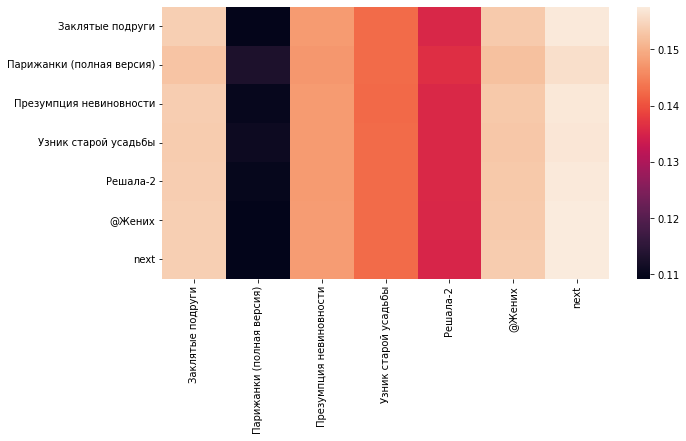

In [52]:
import seaborn as sns

plt.figure(figsize = (10,5))


def show_recommendations_and_explanations(batch, preds, expl, num_head=0):

    
    sampled_user = np.random.choice(np.arange(preds.shape[0]))
    
    user_interactions = [idx2item[t.item()] for t in batch['seq_i'][sampled_user] if t.item() in idx2item \
                     and idx2item[t.item()] != 0]
    decoded_interactions = [itemid2name[x] for x in user_interactions]
    
    while len(decoded_interactions) > 10 or len(decoded_interactions) < 5 :
        sampled_user = np.random.choice(np.arange(preds.shape[0]))
        
        user_interactions = [idx2item[t.item()] for t in batch['seq_i'][sampled_user] if t.item() in idx2item \
                     and idx2item[t.item()] != 0]
        decoded_interactions = [itemid2name[x] for x in user_interactions]

    print(len(decoded_interactions))
    
    user_preds = preds[sampled_user].detach().cpu().numpy()
    recs_for_user = np.argsort(-user_preds)
    recs_for_user_decoded = [idx2item[x-1] for x in np.argsort(-user_preds) if x > 0][:10]
    recs_for_user_named = [itemid2name[x] for x in recs_for_user_decoded]
    
    attention_map = expl[sampled_user].detach().cpu().numpy()[num_head]

    attention_map = attention_map[:batch['seq_len'][sampled_user]+1,:batch['seq_len'][sampled_user]+1]
    sns.heatmap(attention_map,xticklabels=decoded_interactions+['next'], yticklabels=decoded_interactions+['next'])
    
    print('interactions')
    print('recs:', recs_for_user_named)
    
    
    
show_recommendations_and_explanations(batch, preds, expl, num_head=0)



дополнительно про bert4rec полезно послушать свежие две статьи https://www.youtube.com/watch?v=97HVZNB3O5A от Саши Петрова. Там он показывает, что взятая нам имплементация слаба, и можно сделать лучше, что остается за рамками семинара

в оригинальной статье: 

<img src='images/5.png'>

<b> Вопросы:</b>

- Как можно использовать эту матрицу для интерпретации модели?
- Какая картинка матрицы внимания будет у необученной модели?

## VII. Более качественное моделирование поведение пользователей

Вернемся к вопросу с начала семинара:
    
4) Представьте, что вы рекомендуете человеку магазины и видите человека с такой упорядоченной историей:
    - зоомагазин, супермаркет, метрополитен, зоомагазин, кофейня, супермаркет, развлекательный сервис, зоомагазин
   Порекомендуете ли теперь совершить следующую покупку в зоомагазине?

<img src='images/6.png'>

Статья популярная - TiSASRec

<img src='images/8.png'>

Также важно учитывать, что между соседними событями айтемов из одной категории могут проходить какие-то времени

<img src='images/7.png'>

Другая статья с моделью KDA

Toward Dynamic User Intention: Temporal Evolutionary
Effects of Item Relations in Sequential Recommendation

Имплементировать мы это сейчас не будем, есть имплементации готовые, например в ReChorus или RecBole

## VIII. Контекстные рекомендации

Контекст - то, что актуально для пользователя в момент рекомендций

Интеракции - то, что известно в пользователе о прошлом. Контекст - в текущий момент

<b> Вопрос: </b>

1) Какие типы контекста вы можете придумать? Как от них могут изменяться рекомендации?

Можно выделить следующие типы:

1) Время

2) Геолокация

3) Девайс получения рекомендаций

4) Количество денег на счету

5) Поисковый запрос недавний

6) Межличностные отношения

7) Внешние факторы

8) Погода на улице

<b> Вопросы </b>

1) Давайте обсудим, насколько сильное и какое влияние может быть от каждого типа контекста?

2) Предложите свои варианты еще других контекстов?

В общем тут можно много говорить, давайте сразу сделаем наш BERT4Rec контекстной моделью

<img src='images/3.png'>

Мы можем подставить временной контекст под маску (в последний токен), и варьировать его

In [53]:

class ContextBERT4Rec(BERT4Rec):

    def __init__(self, n_items):
        super(BERT4Rec, self).__init__()

        self.weekday_embedding = nn.Embedding(7, 64)
        
        self.n_layers = 2
        self.n_heads = 2
        self.hidden_size = 64  # same as embedding_size
        self.inner_size = 128 # the dimensionality in feed-forward layer
        self.hidden_dropout_prob = 0.2
        self.attn_dropout_prob = 0.2
        self.hidden_act = 'sigmoid'
        self.layer_norm_eps = 1e-5
        self.ITEM_SEQ = 'seq_i'
        self.ITEM_SEQ_LEN = 'seq_len'
        self.max_seq_length = 100
        

        self.mask_ratio = 0.2

        self.loss_type =  'CE'
        self.initializer_range = 1e-2

        # load dataset info
        self.n_items = n_items
        self.mask_token = self.n_items
        self.mask_item_length = int(self.mask_ratio * self.max_seq_length)

        # define layers and loss
        self.item_embedding = nn.Embedding(self.n_items + 1, self.hidden_size, padding_idx=0)  # mask token add 1
        self.position_embedding = nn.Embedding(self.max_seq_length + 1, self.hidden_size)  # add mask_token at the last
        self.trm_encoder = TransformerEncoder(
            n_layers=self.n_layers,
            n_heads=self.n_heads,
            hidden_size=self.hidden_size,
            inner_size=self.inner_size,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attn_dropout_prob=self.attn_dropout_prob,
            hidden_act=self.hidden_act,
            layer_norm_eps=self.layer_norm_eps
        )

        self.LayerNorm = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)
        self.dropout = nn.Dropout(self.hidden_dropout_prob)

        # we only need compute the loss at the masked position
        try:
            assert self.loss_type in ['BPR', 'CE']
        except AssertionError:
            raise AssertionError("Make sure 'loss_type' in ['BPR', 'CE']!")

        # parameters initialization
        self.apply(self._init_weights)



    def reconstruct_test_data(self,
                              item_seq,
                              item_seq_len,
                              dow,
                              dow_valid,
                              particular_day=-1,
                              ):
        """
        Add mask token at the last position according to the lengths of item_seq
        """
        padding = torch.zeros(item_seq.size(0), dtype=torch.long, device=item_seq.device)  # [B]
        item_seq = torch.cat((item_seq, padding.unsqueeze(-1)), dim=-1)  # [B max_len+1]
        dow = torch.cat((dow, padding.unsqueeze(-1)), dim=-1) 
        for batch_id, last_position in enumerate(item_seq_len):
            item_seq[batch_id][last_position] = self.mask_token
            if particular_day == -1:
                dow[batch_id][last_position] = dow_valid[batch_id]
            else:
                dow[batch_id][last_position] = particular_day
        return item_seq, dow

    def forward(self, item_seq, dow, return_explanations=False):
        
        
        dow_embeddings = self.weekday_embedding(dow.long())
        
        position_ids = torch.arange(item_seq.size(1), dtype=torch.long, device=item_seq.device)
        position_ids = position_ids.unsqueeze(0).expand_as(item_seq)
        position_embedding = self.position_embedding(position_ids)
        item_emb = self.item_embedding(item_seq)
        input_emb = item_emb + position_embedding + dow_embeddings
        input_emb = self.LayerNorm(input_emb)
        input_emb = self.dropout(input_emb)
        extended_attention_mask = self.get_attention_mask(item_seq)
        if return_explanations:
            trm_output, explanations = self.trm_encoder(input_emb, extended_attention_mask, output_all_encoded_layers=True,
                                         return_explanations=return_explanations)
        else:
            trm_output = self.trm_encoder(input_emb, extended_attention_mask, output_all_encoded_layers=True,
                                         return_explanations=return_explanations)
            
        output = trm_output[-1]
        
        if return_explanations:
            return output, explanations
        else:
            return output


    def calculate_loss(self, interaction):
        item_seq = interaction[self.ITEM_SEQ].long()
        masked_item_seq, pos_items, neg_items, masked_index = self.reconstruct_train_data(item_seq)

        seq_output = self.forward(masked_item_seq, dow=interaction['dow'])
        pred_index_map = self.multi_hot_embed(masked_index, masked_item_seq.size(-1))  # [B*mask_len max_len]
        # [B mask_len] -> [B mask_len max_len] multi hot
        pred_index_map = pred_index_map.view(masked_index.size(0), masked_index.size(1), -1)  # [B mask_len max_len]
        # [B mask_len max_len] * [B max_len H] -> [B mask_len H]
        # only calculate loss for masked position
        seq_output = torch.bmm(pred_index_map, seq_output)  # [B mask_len H]

        if self.loss_type == 'BPR':
            pos_items_emb = self.item_embedding(pos_items)  # [B mask_len H]
            neg_items_emb = self.item_embedding(neg_items)  # [B mask_len H]
            pos_score = torch.sum(seq_output * pos_items_emb, dim=-1)  # [B mask_len]
            neg_score = torch.sum(seq_output * neg_items_emb, dim=-1)  # [B mask_len]
            targets = (masked_index > 0).float()
            loss = - torch.sum(torch.log(1e-14 + torch.sigmoid(pos_score - neg_score)) * targets) \
                   / torch.sum(targets)
            return loss

        elif self.loss_type == 'CE':
            loss_fct = nn.CrossEntropyLoss(reduction='none')
            test_item_emb = self.item_embedding.weight[:self.n_items]  # [item_num H]
            logits = torch.matmul(seq_output, test_item_emb.transpose(0, 1))  # [B mask_len item_num]
            targets = (masked_index > 0).float().view(-1)  # [B*mask_len]

            loss = torch.sum(loss_fct(logits.view(-1, test_item_emb.size(0)), pos_items.view(-1)) * targets) \
                   / torch.sum(targets)
            return loss
        else:
            raise NotImplementedError("Make sure 'loss_type' in ['BPR', 'CE']!")


    def full_sort_predict(self, 
                          interaction,
                          return_explanations=False,
                          particular_day=-1):
        
        item_seq = interaction[self.ITEM_SEQ].long()
        item_seq_len = interaction[self.ITEM_SEQ_LEN].long()
        item_seq, dow = self.reconstruct_test_data(item_seq,
                                              item_seq_len,
                                              dow=interaction['dow'],
                                              dow_valid=interaction['dow_valid'].long(),
                                              particular_day=particular_day)
        
        
        if return_explanations:
            seq_output, expl = self.forward(item_seq,
                                            dow=dow,
                                            return_explanations=return_explanations)
        else:
            seq_output = self.forward(item_seq,
                                      dow=dow,
                                      return_explanations=return_explanations)
            
        
        seq_output = self.gather_indexes(seq_output, item_seq_len - 1)  # [B H]
        test_items_emb = self.item_embedding.weight[:self.n_items]  # delete masked token
        scores = torch.matmul(seq_output, test_items_emb.transpose(0, 1))  # [B, item_num]
                
        idxs = item_seq.nonzero()
        item_seq[item_seq==self.n_items] = 0
        scores[idxs[:,0], item_seq[idxs[:,0],idxs[:,1]].long()] = -1000

        if return_explanations:
            return scores, expl
        else:
            return scores

    
    


In [54]:

model = ContextBERT4Rec(n_items=len(item2idx)+1)

optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
engine = dl.DeviceEngine('cpu')
hparams = {
    "anneal_cap": 0.2,
    "total_anneal_steps": 6000,
}


callbacks = [
    dl.NDCGCallback("logits", "targets", [20]),
    dl.MAPCallback("logits", "targets", [10]),
    #dl.MRRCallback("logits", "targets", [20, 50, 100]),
    #dl.HitrateCdallback("logits", "targets", [20, 50, 100]),
    dl.OptimizerCallback("loss", accumulation_steps=1),
    dl.EarlyStoppingCallback(
        patience=5, loader_key="valid", metric_key="map10", minimize=False
    )
]


runner = RecSysRunner()
runner.train(
    model=model,
    optimizer=optimizer,
    engine=engine,
    hparams=hparams,
    scheduler=lr_scheduler,
    loaders=loaders,
    num_epochs=5,
    verbose=True,
    timeit=True,
    callbacks=callbacks,
    #logdir="./logs",
)


/usr/local/lib/python3.7/site-packages/catalyst/core/runner.py:638: UserWarning: No ``ISchedulerCallback/SchedulerCallback`` were found while runner.scheduler is not None.Do you make scheduler step during ``runner.handle_batch``?
  "No ``ISchedulerCallback/SchedulerCallback`` were found "


1/5 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (1/5) loss: 8.459012211608888 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


1/5 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (1/5) loss: 7.913002435302735 | lr: 0.001 | map10: 0.08979082796573638 | map10/std: 0.015451208284442047 | momentum: 0.9 | ndcg20: 0.09712186888456344 | ndcg20/std: 0.011222024264848545
* Epoch (1/5) 


2/5 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (2/5) loss: 7.761012598419189 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


2/5 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (2/5) loss: 7.458164292907714 | lr: 0.001 | map10: 0.1076800211429596 | map10/std: 0.014903637205744832 | momentum: 0.9 | ndcg20: 0.10964286289215087 | ndcg20/std: 0.011712100963375896
* Epoch (2/5) 


3/5 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (3/5) loss: 7.505968649291993 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


3/5 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (3/5) loss: 7.387365798950195 | lr: 0.001 | map10: 0.10781053624153139 | map10/std: 0.01619631917088189 | momentum: 0.9 | ndcg20: 0.1119542230606079 | ndcg20/std: 0.011830521195496739
* Epoch (3/5) 


4/5 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (4/5) loss: 7.433365428161621 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


4/5 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (4/5) loss: 7.356972218322754 | lr: 0.001 | map10: 0.1260868020296097 | map10/std: 0.018576002719429417 | momentum: 0.9 | ndcg20: 0.11880033075809479 | ndcg20/std: 0.014939629936590204
* Epoch (4/5) 


5/5 * Epoch (train):   0%|          | 0/20 [00:00<?, ?it/s]

train (5/5) loss: 7.420101595306396 | lr: 0.001 | map10: 0.0 | map10/std: 0.0 | momentum: 0.9 | ndcg20: 0.0 | ndcg20/std: 0.0


5/5 * Epoch (valid):   0%|          | 0/20 [00:00<?, ?it/s]

valid (5/5) loss: 7.3294425895690924 | lr: 0.001 | map10: 0.12527201335430146 | map10/std: 0.01626399883946588 | momentum: 0.9 | ndcg20: 0.11997740316390992 | ndcg20/std: 0.013181571112957178
* Epoch (5/5) 


In [55]:
model.eval()

ranks_dow = {}

for dow in tqdm(range(6)):

    item2rank = defaultdict(list)

    for batch in loaders['valid']:

        preds = model.full_sort_predict(batch, return_explanations=False, particular_day=dow )
        preds = (preds.argsort())[:,-10:]

        for j  in range(preds.shape[0]):
            for i in range(len(preds[j])):
                item2rank[itemid2name[idx2item[preds[j][i].item()-1]]].append(i)

    item2rank_averaged = {k: np.mean(item2rank[k]) for k in item2rank if len(item2rank[k]) > 10}
    ranks_dow[dow] = item2rank_averaged



100%|██████████| 6/6 [00:50<00:00,  8.38s/it]


<AxesSubplot:>

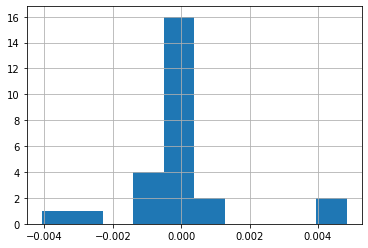

In [56]:
res_change = pd.DataFrame.from_dict(ranks_dow)

res_change['diff_ranks'] =  res_change[4] - res_change[0]
res_change.diff_ranks.hist()

In [57]:
res_change.sort_values(by='diff_ranks', ascending=True).tail(30)

,0,1,2,3,4,5,diff_ranks
Маша,2.270838,2.255310,2.279874,2.273549,2.266772,2.270899,-0.004066
100% волк,1.469565,1.467014,1.469565,1.469565,1.467014,1.469565,-0.002551
Белый снег,1.467756,1.467811,1.465577,1.465577,1.466495,1.465236,-0.001261
Подслушано,3.100786,3.103704,3.099214,3.099888,3.099663,3.099439,-0.001122
Пальмира,1.314042,1.314324,1.313285,1.314183,1.313453,1.313620,-0.000589
Девятаев,6.690096,6.689031,6.690628,6.690628,6.689563,6.690362,-0.000532
Гнев человеческий,8.241564,8.241564,8.241845,8.241282,8.241564,8.241564,0.000000
Стендап под прикрытием,1.200000,1.200000,1.200000,1.200000,1.200000,1.200000,0.000000
Радиовспышка,1.470588,1.470588,1.470588,1.470588,1.470588,1.470588,0.000000
Зверополис,1.030303,1.030303,1.030303,1.030303,1.030303,1.030303,0.000000


<AxesSubplot:>

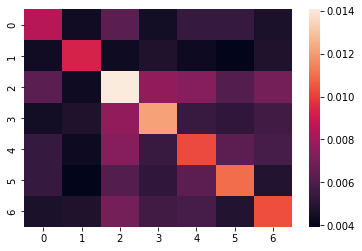

In [58]:
embeddings = model.weekday_embedding.weight.detach().cpu().numpy()

weight_mat = (embeddings @ embeddings.T)

sns.heatmap(weight_mat)

вставляем контекст в двухуровневые модели

In [99]:
df = pd.read_csv('../../mts_data_show.csv.gz', nrows=100000)
df.head()

,user_id,item_id,snd_lvl_items,item_col_labels,knn_assym,p3alpha,perspop,knn_dice,ease_score,ease,gfcf,knn_jaccard,multvae,multvae_rank
0,1001400,11145,11145,0,0.0,0.0,0.0,0.0,0.000068,1187.0,-0.003725,0.0,-8.048315,-8.048315
1,1001400,11322,11322,0,0.0,0.0,0.0,0.0,0.000097,758.0,-0.001584,0.0,-7.001169,-7.001169
2,1001400,11382,11382,0,0.0,0.0,0.0,0.0,0.000138,380.0,0.007342,0.0,-7.775056,-7.775056
3,1001400,1238,1238,0,0.0,0.0,0.0,0.0,0.000072,1121.0,0.009378,0.0,-8.827324,-8.827324
4,1001400,13058,13058,0,0.0,0.0,0.0,0.0,0.000099,737.0,-0.000888,0.0,-6.859427,-6.859427


In [100]:
df.loc[df.item_col_labels==1].head()

,user_id,item_id,snd_lvl_items,item_col_labels,knn_assym,p3alpha,perspop,knn_dice,ease_score,ease,gfcf,knn_jaccard,multvae,multvae_rank
13,1001400,4141,4141,1,0.000000,0.000000,0.0,0.000000,0.000114,578.0,0.001373,0.000000,-7.197251,-7.197251
27,1002049,12138,12138,1,0.213457,0.016396,0.0,0.021227,0.000847,402.0,0.018966,0.022890,-7.463271,-7.463271
34,1002049,15994,15994,1,0.056335,0.000000,0.0,0.002985,0.000415,1446.0,0.011384,0.003231,-7.922297,-7.922297
39,1002049,4457,4457,1,1.696066,0.073237,0.0,0.529603,0.001610,19.0,0.097332,0.575680,-5.300034,-5.300034
45,1002049,8221,8221,1,0.227332,0.011842,0.0,0.000000,0.000493,1218.0,0.004946,0.000000,-8.551929,-8.551929


In [101]:
df['device'] = np.random.choice(['mobile','tv'], size=df.shape[0])
df['time_of_recs'] = np.random.choice(np.arange(24), size=df.shape[0])
df.head()

,user_id,item_id,snd_lvl_items,item_col_labels,knn_assym,p3alpha,perspop,knn_dice,ease_score,ease,gfcf,knn_jaccard,multvae,multvae_rank,device,time_of_recs
0,1001400,11145,11145,0,0.0,0.0,0.0,0.0,0.000068,1187.0,-0.003725,0.0,-8.048315,-8.048315,tv,23
1,1001400,11322,11322,0,0.0,0.0,0.0,0.0,0.000097,758.0,-0.001584,0.0,-7.001169,-7.001169,mobile,18
2,1001400,11382,11382,0,0.0,0.0,0.0,0.0,0.000138,380.0,0.007342,0.0,-7.775056,-7.775056,tv,5
3,1001400,1238,1238,0,0.0,0.0,0.0,0.0,0.000072,1121.0,0.009378,0.0,-8.827324,-8.827324,mobile,11
4,1001400,13058,13058,0,0.0,0.0,0.0,0.0,0.000099,737.0,-0.000888,0.0,-6.859427,-6.859427,mobile,6


на трейне обучаемся на актуальных данных, на тесте можем подставлять контекст

In [104]:
model.item_embedding.weight

Parameter containing:
tensor([[ 0.0582, -0.0422, -0.0457,  ..., -0.0530,  0.0737,  0.0708],
        [ 0.0294, -0.0212,  0.0024,  ..., -0.0509,  0.0098,  0.0290],
        [ 0.0543, -0.0498, -0.0293,  ..., -0.0298,  0.0505,  0.0641],
        ...,
        [ 0.0293, -0.0368, -0.0229,  ..., -0.0377,  0.0425,  0.0359],
        [ 0.0330, -0.0282, -0.0219,  ..., -0.0368,  0.0259,  0.0389],
        [-0.0238,  0.0187,  0.0157,  ...,  0.0304, -0.0071, -0.0180]],
       requires_grad=True)

## IX. Еще мысли для обсуждения

- Не всегда последовательность лучше учитывать. Например корзина продуктов - тут в целом не важно, в какой последовательности вы покупали товары

- В некоторых датасетах есть неопределенность с точным порядком (movielens как пример)



In [ ]:
!mkdir ./data_ckpt/ -d

from slist import SLIST

class SLISTRecommender:

    def __init__(self):

        self.trained = False
    
    def fit(self, df, col='train_interactions', n_rows=30000):
        
        df['Time'] = pd.to_datetime(df['last_watch_dt']).astype(int) / 10**9
        self.slist = SLIST(session_key='user_id', item_key='item_id',)

        self.slist.fit(df[:n_rows])
        
        self.items = df.item_id.unique()
        

        self.trained = True
        
    def predict(self, df, topn=10) -> List[np.ndarray]:
        
        assert self.trained
         
        all_recs = []
        
        
        for idx, row in tqdm(df.iterrows()):
            
            user_recs = []
            
            user_interactions = [x[0] for x in row['train_interactions']]
            user_interactions += [x[0] for x in row['valid_interactions']]
            
            user_interactions = [x for x in user_interactions if x in set(self.slist.itemidmap.index)]
            
            if len(user_interactions) == 0:
                recs = [10440, 9728, 13865]
                all_recs.append(recs[:topn])
                continue
           # print(user_interactions)
            
            recs = self.slist.predict_next(user_interactions, topn=10+len(user_interactions))
            all_recs.append(recs[:topn])
            
        return all_recs

In [ ]:
slist_r = SLISTRecommender()
slist_r.fit(train_df, n_rows=train_df.shape[0])
joined['slist_recs'] = slist_r.predict(joined) 

In [ ]:
evaluate_recommender(joined, model_preds='slist_recs')